---
**Turma:** 15

**Grupo:** 11 - Bruno Correia, Gilson Costa, Vivian Liu

**Contato**: `brunovpm@hotmail.com, gilson.costa@gmail.com, liuoliveira.vivian@gmail.com`


**Licença deste notebook**:
![CC BY](https://licensebuttons.net/l/by/3.0/88x31.png)

[Clique aqui para saber mais sobre a licença CC BY v4.0](https://creativecommons.org/licenses/by/4.0/legalcode.pt)

---
# Regressão Logistica

In [0]:
root_dir = '/dbfs/FileStore/ifood'

dbutils.fs.ls(f'{root_dir}')

Out[1]: [FileInfo(path='dbfs:/dbfs/FileStore/ifood/abt/', name='abt/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/customer_segmentation/', name='customer_segmentation/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/enrich/', name='enrich/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/marketing_push_full/', name='marketing_push_full/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/orders/', name='orders/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/orders_with_cost_revenue/', name='orders_with_cost_revenue/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/preprocess/', name='preprocess/', size=0),
 FileInfo(path='dbfs:/dbfs/FileStore/ifood/sessions_visits/', name='sessions_visits/', size=0)]

### Load ABT Train Test

In [0]:
abt = 'abt_case_aug_half_end'

df_abt_case_train = spark.read.parquet(
  f'{root_dir}/abt/{abt}_train'
).repartition(2).cache()
df_abt_case_train.createOrReplaceTempView(f'{abt}_train')
df_abt_case_train.createOrReplaceTempView('abt_train')

df_abt_case_test = spark.read.parquet(
  f'{root_dir}/abt/{abt}_test'
).repartition(2).cache()
df_abt_case_test.createOrReplaceTempView(f'{abt}_test')
df_abt_case_test.createOrReplaceTempView('abt_test')

df_abt_case_train.count(), df_abt_case_test.count()

Out[2]: (21036, 9043)

### VectorAssembler

In [0]:
from pyspark.ml.feature import VectorAssembler

featureList = [
  'orders_last_91d',
  'qtt_valid_orders',
  'qtt_invalid_orders',
  'customer_lifetime_days',
  'rfv_score',
  'merchant_variety',
  'merchant_offer',
  'total_send',
  'total_bounce',
  'total_click',
  'sum_event_open',
  'label_last_month'
]

assembler = VectorAssembler(inputCols=featureList, outputCol = 'features')

dfAssemblerTrain = assembler.transform(df_abt_case_train)
dfAssemblerTest  = assembler.transform(df_abt_case_test)

# GridSearch

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression

estimator = LogisticRegression()

paramGrid = ParamGridBuilder() \
    .addGrid(estimator.regParam, [0.0, 0.03, 0.1])\
    .addGrid(estimator.elasticNetParam, [0.4, 0.6])\
    .build()

evaluator = BinaryClassificationEvaluator()
evaluator.setMetricName("areaUnderROC")

crossval = CrossValidator(
  estimator=estimator,
  estimatorParamMaps=paramGrid,
  evaluator=evaluator,
  parallelism=3,
  numFolds=5
)

import time

dfAssemblerTrain.cache()

ti = time.time()
cvModel = crossval.fit(dfAssemblerTrain)
tf = time.time()

/databricks/spark/python/pyspark/ml/util.py:791: UserWarning: Can not find mlflow. To enable mlflow logging, install MLflow library from PyPi.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)

In [0]:
import pandas as pd

pdSummaryParam = pd.DataFrame(cvModel.getEstimatorParamMaps())
pdSummaryParam['avgMetrics'] = cvModel.avgMetrics
pdSummaryParam.columns = ['regParam', 'elasticNetParam', 'underROC']

pdSummaryParam.sort_values('underROC', ascending=False)

,regParam,elasticNetParam,underROC
0,0.00,0.4,0.936569
1,0.00,0.6,0.936569
3,0.03,0.6,0.886067
2,0.03,0.4,0.883126
4,0.10,0.4,0.858572
5,0.10,0.6,0.851265


### Evaluation on Test

In [0]:
dfCvPrediction = cvModel.transform(dfAssemblerTest)

In [0]:
from sklearn.metrics import classification_report 
import pandas as pd
pd.set_option('display.precision', 6)

pdCvReport = dfCvPrediction.select('label', 'prediction').toPandas()

#### Metric ROC PR

In [0]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
            
        # Separa em FPR e TPR
        fpr = []
        tpr = []
        for f, t in points:
          fpr.append(f)
          tpr.append(t)
        
        return fpr, tpr

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

In [0]:
import pandas as pd

evaluator = BinaryClassificationEvaluator()

pdCvMetric = pd.DataFrame({
  "areaUnderROC": [evaluator.setMetricName("areaUnderROC").evaluate(dfCvPrediction)],
  "areaUnderPR": [evaluator.setMetricName("areaUnderPR").evaluate(dfCvPrediction)]
})

pdCvMetric.transpose()

,0
areaUnderROC,0.940926
areaUnderPR,0.903315


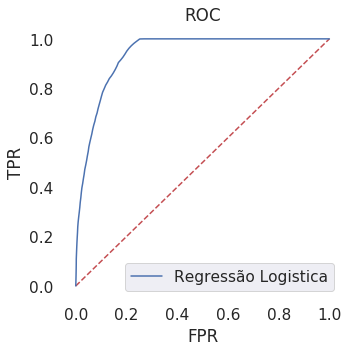

In [0]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))
plt.plot([0, 1], [0.0, 1.0], 'r--')

plt.plot(
  cvModel.bestModel.summary.roc.select('FPR').collect(),
  cvModel.bestModel.summary.roc.select('TPR').collect(),
  label='Regressão Logistica'
)

plt.title('ROC')
plt.legend(loc="best")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#### Classification Report

In [0]:
pd.DataFrame(
  classification_report(pdCvReport['label'], pdCvReport['prediction'], output_dict=True)
)

,0,1,micro avg,macro avg,weighted avg
f1-score,0.876390,0.867644,0.872166,0.872017,0.872555
precision,0.958821,0.794506,0.872166,0.876663,0.886775
recall,0.807011,0.955612,0.872166,0.881311,0.872166
support,5078.000000,3965.000000,9043.000000,9043.000000,9043.000000


#### Confussion Matrix

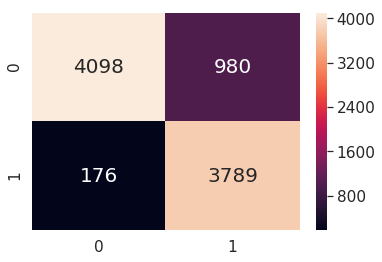

In [0]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

pdCvMatrix = dfCvPrediction.select('label', 'prediction').toPandas()

cm = confusion_matrix(pdCvMatrix['label'], pdCvMatrix['prediction'])

sns.set(font_scale=1.4)
sns.heatmap(cm, annot=True, annot_kws={"size": 20}, fmt='g')

In [0]:
import pandas as pd
import numpy as np

print("Intercept: " + str(cvModel.bestModel.intercept))

pdCoef = pd.DataFrame()
pdCoef['column'] = featureList
pdCoef['coefficient'] = list(cvModel.bestModel.coefficients)
#pdCoef['Intercept'] = model.stages[-1].intercept

pdCoef['sort'] = np.abs(pdCoef['coefficient'])
pdCoef.sort_values(by='sort', ascending=False).drop(columns=['sort'])

,column,coefficient
10,sum_event_open,-17.233586
11,label_last_month,1.000450
5,merchant_variety,0.647545
8,total_bounce,0.206824
0,orders_last_91d,-0.047414
9,total_click,-0.045596
2,qtt_invalid_orders,0.039007
4,rfv_score,0.017920
7,total_send,-0.004982
1,qtt_valid_orders,-0.004545


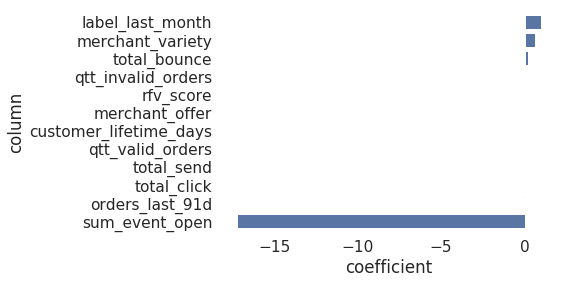

In [0]:
import seaborn as sns 
sns.barplot(x='coefficient',y='column', data=pdCoef.sort_values(by='coefficient', ascending=False), color="b")